In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, mean, when, isnull

# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
spark = SparkSession.builder \
                    .appName("Tutorial_DF") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()

In [4]:
spark

In [6]:
# Load CSV into DataFrame
file_path = "PlayerDataset.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the first 5 rows
print("Showing first 5 rows:")
df.show(5)

# Print schema of the DataFrame
print("Schema of DataFrame:")
df.printSchema(1)

Showing first 5 rows:
+---+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+------------+----+-------+------------+----------+-------+-------+------------+---------+--------+-----+---------+---------+------------------+---------+-----------+----------+--------------+-----------+----------------+-------------+-------+------------+----------+-------+---------+-----------+---------+-------------+----------+--------------+------------+-------+---------------+--------+------+-------+----+----+----+----+----+------+----+----+----+----+----+----+----+----+----+----+-------------------+----+----+----+----+----+----+----+----+----+----+----+
|_c0|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|Player_Value|Wage|Special|Acceleration|Aggression|Agility|Balance|Ball control|Composure|Crossing|Curve|Dribbling|Finishing|Free_kick

In [7]:
#find number of partition
num_partitions = df.rdd.getNumPartitions()
print(f"Number of partitions: {num_partitions}")

Number of partitions: 2


In [8]:
#Reparition
df = df.repartition(10)
num_partitions = df.rdd.getNumPartitions()
print(f"Number of partitions: {num_partitions}")

Number of partitions: 10


In [9]:
# Find total number of columns and rows
print("Total number of columns and rows:")
num_columns = len(df.columns)
num_rows = df.count()
print(f"Number of columns: {num_columns}, Number of rows: {num_rows}")

Total number of columns and rows:
Number of columns: 75, Number of rows: 17981


In [10]:
df.describe().show()

+-------+-----------------+-------------+------------------+--------------------+-----------+--------------------+-----------------+-----------------+--------------------+--------------------+-----------------+-----+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-------------

In [11]:
# Fill missing values with appropriate default values
# For numeric columns, fill with 0; for string columns, fill with 'Unknown'
print("Filling missing values:")
fill_values = {col_name: 0 if dtype.startswith("int") \
                or dtype.startswith("double") \
                else "Unknown"\
                for col_name, dtype in df.dtypes}
df_filled = df.fillna(fill_values)
df_filled.show(5)

Filling missing values:
+----+----------+---+--------------------+-----------+--------------------+-------+---------+----------------+--------------------+------------+----+-------+------------+----------+-------+-------+------------+---------+--------+-----+---------+---------+------------------+---------+-----------+----------+--------------+-----------+----------------+-------------+-------+------------+----------+-------+---------+-----------+---------+-------------+----------+--------------+------------+-------+---------------+--------+------+-------+---+---+---+---+---+------+---+---+---+---+---+---+---+---+---+---+-------------------+---+---+---+---+---+---+---+---+---+---+---+
| _c0|      Name|Age|               Photo|Nationality|                Flag|Overall|Potential|            Club|           Club Logo|Player_Value|Wage|Special|Acceleration|Aggression|Agility|Balance|Ball control|Composure|Crossing|Curve|Dribbling|Finishing|Free_kick accuracy|GK_diving|GK_handling|GK_kicking

In [12]:
# Rename columns (example renaming)
print("Renaming columns:")
new_column_names = {"Name": "Player_Name", "Age": "Player_Age", "Nationality": "Country"}
for old_name, new_name in new_column_names.items():
    df_filled = df_filled.withColumnRenamed(old_name, new_name)

# Show updated column names
print("Updated DataFrame with renamed columns:")
df_filled.show(5)

Renaming columns:
Updated DataFrame with renamed columns:
+----+-----------+----------+--------------------+-------+--------------------+-------+---------+----------------+--------------------+------------+----+-------+------------+----------+-------+-------+------------+---------+--------+-----+---------+---------+------------------+---------+-----------+----------+--------------+-----------+----------------+-------------+-------+------------+----------+-------+---------+-----------+---------+-------------+----------+--------------+------------+-------+---------------+--------+------+-------+---+---+---+---+---+------+---+---+---+---+---+---+---+---+---+---+-------------------+---+---+---+---+---+---+---+---+---+---+---+
| _c0|Player_Name|Player_Age|               Photo|Country|                Flag|Overall|Potential|            Club|           Club Logo|Player_Value|Wage|Special|Acceleration|Aggression|Agility|Balance|Ball control|Composure|Crossing|Curve|Dribbling|Finishing|Free_kick

In [13]:
# Select specific columns
print("Selecting columns Player_Name and Player_Age:")
df_filled.select("Player_Name", "Player_Age").show(5)

# Show distinct nationalities
print("Distinct countries:")
df_filled.select("Country").distinct().show()

Selecting columns Player_Name and Player_Age:
+--------------+----------+
|   Player_Name|Player_Age|
+--------------+----------+
|    E. Quejeda|        29|
|  L. Escalante|        25|
|   M. Ballmert|        23|
|Iuliano Alfaro|        29|
|    D. Vaughan|        34|
+--------------+----------+
only showing top 5 rows

Distinct countries:
+-----------------+
|          Country|
+-----------------+
|         Paraguay|
|           Russia|
|          Senegal|
|           Sweden|
|           Guyana|
|           Turkey|
|             Iraq|
|   St Kitts Nevis|
|          Germany|
|          Comoros|
|      Ivory Coast|
|           France|
|           Greece|
|           Kosovo|
|         DR Congo|
|          Algeria|
|Equatorial Guinea|
|         Slovakia|
|        Argentina|
|            Wales|
+-----------------+
only showing top 20 rows



In [14]:
# Filtering rows where Overall > 90
print("Filtering players with Overall > 90:")
df_filled.filter(col("Overall") > 90).select("Player_Name", "Overall")\
.show()

# Filtering rows where Player_Age < 25
print("Filtering players younger than 25:")
df_filled.filter(col("Player_Age") < 25)\
.select("Player_Name", "Player_Age").show()

Filtering players with Overall > 90:
+-----------------+-------+
|      Player_Name|Overall|
+-----------------+-------+
|   R. Lewandowski|     91|
|        L. Suárez|     92|
|Cristiano Ronaldo|     94|
|           Neymar|     92|
|         L. Messi|     93|
|         M. Neuer|     92|
+-----------------+-------+

Filtering players younger than 25:
+--------------+----------+
|   Player_Name|Player_Age|
+--------------+----------+
|      F. Forte|        24|
| V. Klonaridis|        24|
|    Iván Alejo|        22|
|     A. Castro|        22|
|    H. Manzala|        23|
|        Nathan|        21|
|   R. Leipertz|        24|
|F. Monteseirín|        22|
|     M. Icardi|        24|
| K. Rosenberry|        23|
|     D. Granli|        23|
|      M. Romeo|        21|
|   A. Escoboza|        24|
|   C. Paterson|        22|
|     K. Harris|        24|
|       J. Vela|        24|
|        G. Gül|        18|
|      Verdasca|        20|
|      R. Rabei|        22|
|Rúben Oliveira|        22|
+--

In [15]:
# Group by Country and count players
print("Grouping by Country and counting players:")
df_filled.groupBy("Country").count().show(5)

Grouping by Country and counting players:
+--------+-----+
| Country|count|
+--------+-----+
|Paraguay|   69|
|  Russia|  306|
| Senegal|  129|
|  Sweden|  368|
|  Guyana|    5|
+--------+-----+
only showing top 5 rows



In [16]:
# Group by Club and calculate average player overall rating
print("Group by Club and calculate average Overall:")
df_filled.groupBy("Club")\
.agg(mean("Overall").alias("Average Overall"))\
.show(5)

# Average player rating by country
print("Average player rating by country:")
average_rating_by_country = df_filled.groupBy("Country")\
.agg(mean("Overall").alias("Average Rating"))\
.orderBy(col("Average Rating").desc())

Group by Club and calculate average Overall:
+------------------+-----------------+
|              Club|  Average Overall|
+------------------+-----------------+
|           Palermo|66.17857142857143|
|       Yeovil Town|59.76190476190476|
|1. FC Union Berlin|68.11111111111111|
|        Sagan Tosu|            63.44|
|             Carpi|64.03333333333333|
+------------------+-----------------+
only showing top 5 rows

Average player rating by country:


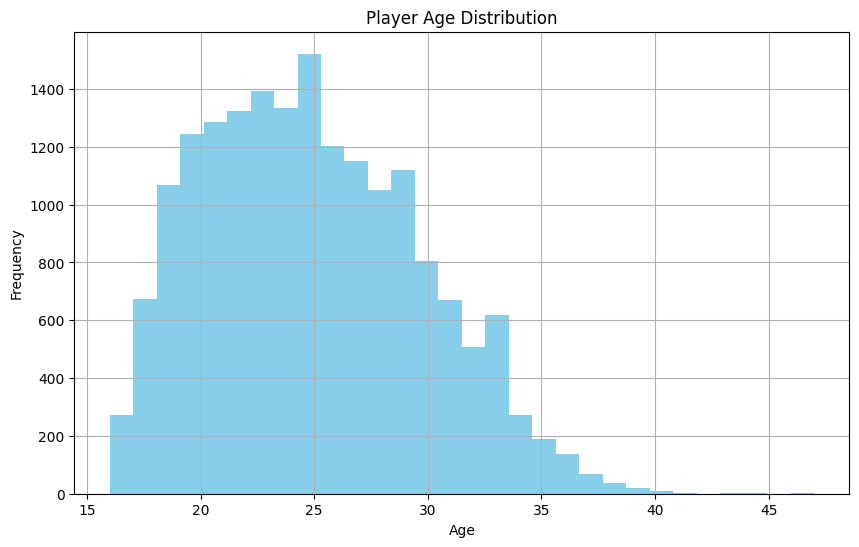

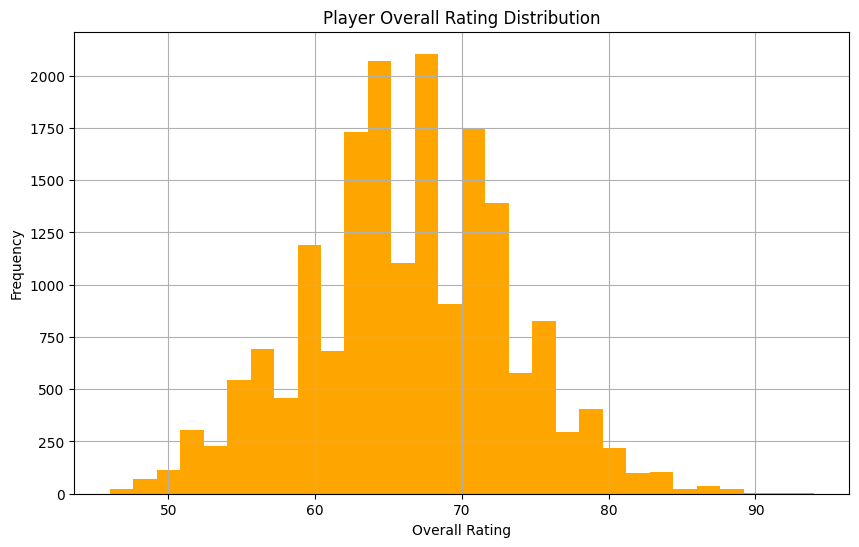

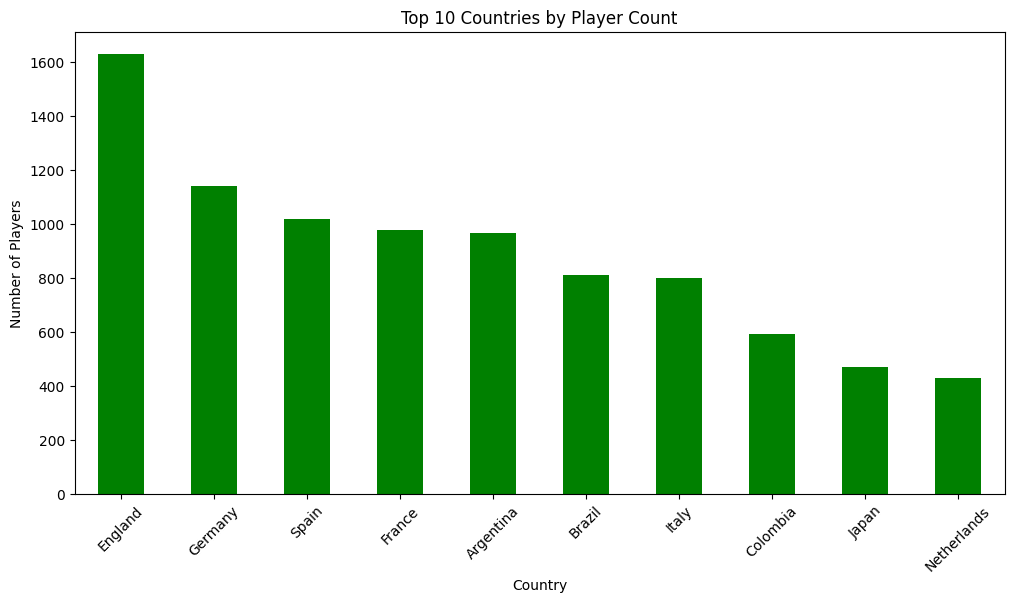

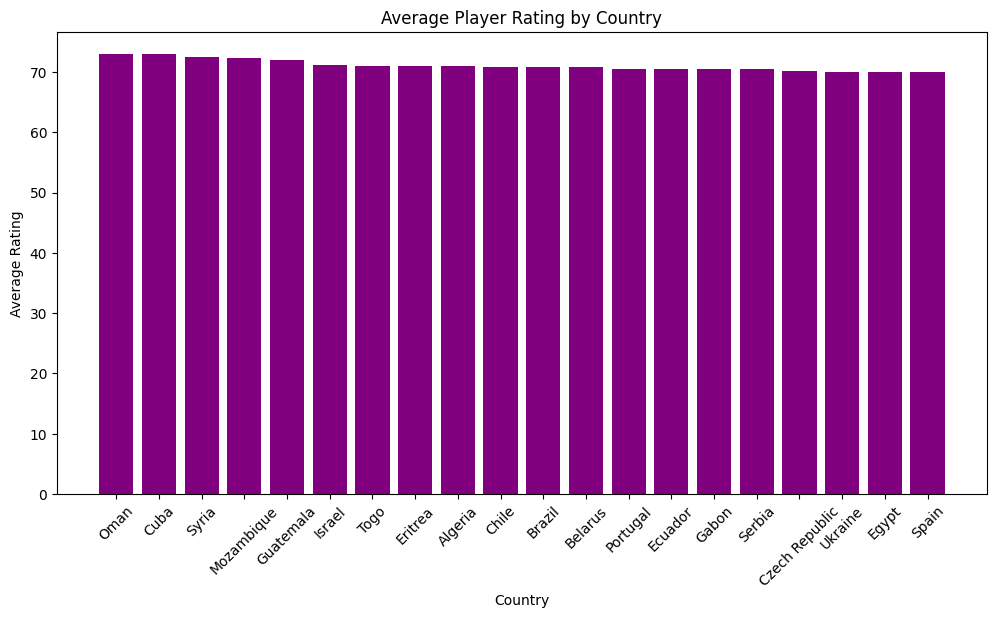

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
# Visualization: Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = df_filled.select("Player_Age", "Overall", "Country").toPandas()

# Plot Age Distribution
plt.figure(figsize=(10, 6))
pandas_df["Player_Age"].hist(bins=30, color='skyblue')
plt.title("Player Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Plot Overall Rating Distribution
plt.figure(figsize=(10, 6))
pandas_df["Overall"].hist(bins=30, color='orange')
plt.title("Player Overall Rating Distribution")
plt.xlabel("Overall Rating")
plt.ylabel("Frequency")
plt.show()

# Bar Plot of Top 10 Countries by Player Count
country_counts = pandas_df["Country"].value_counts().head(10)
plt.figure(figsize=(12, 6))
country_counts.plot(kind='bar', color='green')
plt.title("Top 10 Countries by Player Count")
plt.xlabel("Country")
plt.ylabel("Number of Players")
plt.xticks(rotation=45)
plt.show()


# Bar Plot of top10 Average Player Rating by Country
average_rating_pd_df = average_rating_by_country.toPandas()
average_rating_pd_df=average_rating_pd_df.head(20)
plt.figure(figsize=(12, 6))
plt.bar(average_rating_pd_df["Country"],
        average_rating_pd_df["Average Rating"], color='purple')
plt.title("Average Player Rating by Country")
plt.xlabel("Country")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()

In [18]:
df.createOrReplaceTempView("players")

In [19]:
# Q6: Club performance overview (for bubble chart)
q6 = spark.sql("""
    SELECT Club,
           COUNT(*) AS PlayerCount,
           ROUND(AVG(Overall), 1) AS AvgOverall,
           ROUND(sum(player_Value), 2) AS TotalValueM
    FROM players
    WHERE Club IS NOT NULL AND player_Value IS NOT NULL
    GROUP BY Club
    HAVING PlayerCount > 10
    ORDER BY TotalValueM DESC
""").toPandas()

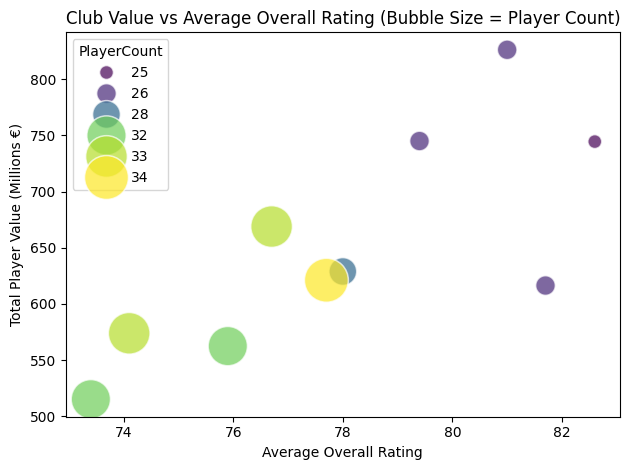

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(
    data=q6.head(10),
    x="AvgOverall",
    y="TotalValueM",
    size="PlayerCount",
    hue="PlayerCount",
    palette="viridis",
    legend=True,

    sizes=(100, 1000),
    alpha=0.7
)
plt.title("Club Value vs Average Overall Rating (Bubble Size = Player Count)")
plt.xlabel("Average Overall Rating")
plt.ylabel("Total Player Value (Millions €)")
plt.tight_layout()
plt.show()

In [22]:
# Q7: Position groups distribution
q7 = spark.sql("""
    SELECT
        CASE
            WHEN `Preferred_Positions` LIKE '%GK%' THEN 'Goalkeeper'
            WHEN `Preferred_Positions` RLIKE 'CB|RB|LB|RWB|LWB' THEN 'Defender'
            WHEN `Preferred_Positions` RLIKE 'CM|CDM|CAM|RM|LM' THEN 'Midfielder'
            WHEN `Preferred_Positions` RLIKE 'ST|CF|LW|RW' THEN 'Forward'
            ELSE 'Other'
        END AS PositionGroup,
        COUNT(*) AS NumPlayers
    FROM players
    GROUP BY PositionGroup
""").toPandas()

/tmp/ipython-input-23-3390137345.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=q7, x="PositionGroup", y="NumPlayers", palette="muted")


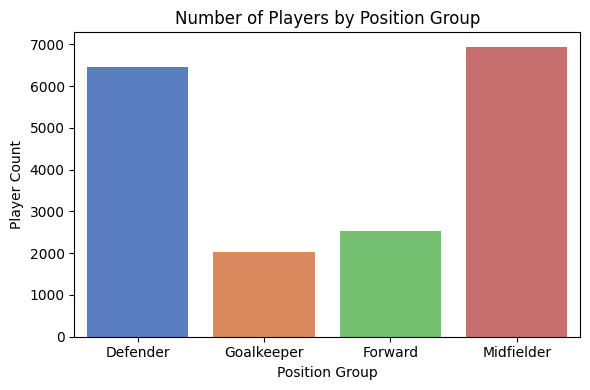

In [23]:
plt.figure(figsize=(6, 4))
sns.barplot(data=q7, x="PositionGroup", y="NumPlayers", palette="muted")
plt.title("Number of Players by Position Group")
plt.xlabel("Position Group")
plt.ylabel("Player Count")
plt.tight_layout()
plt.show()

In [24]:
# Q8: Age vs Value
q8 = spark.sql("""
    SELECT Age, player_Value
    FROM players
    WHERE Age IS NOT NULL AND player_Value IS NOT NULL
""").toPandas()

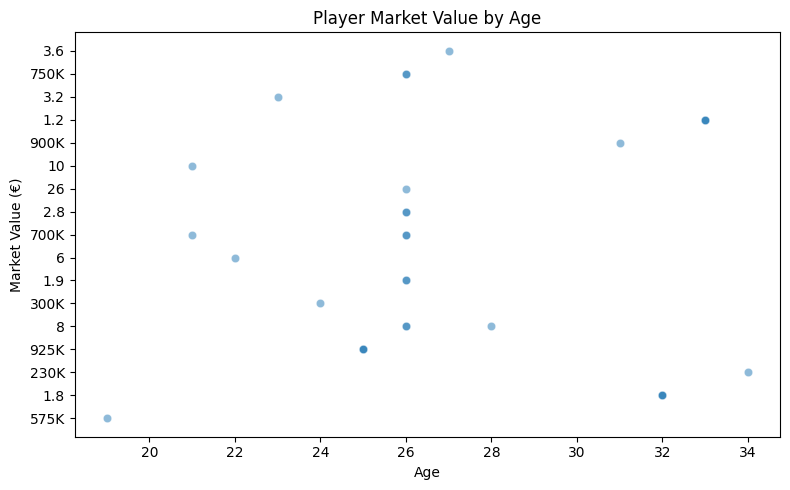

In [25]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=q8.head(30), x="Age", y="player_Value", alpha=0.5)
plt.title("Player Market Value by Age")
plt.xlabel("Age")
plt.ylabel("Market Value (€)")
plt.tight_layout()
plt.show()

In [26]:
q8.head(15)

,Age,player_Value
0,27,3.6
1,26,750K
2,26,750K
3,23,3.2
4,33,1.2
5,33,1.2
6,33,1.2
7,31,900K
8,21,10
9,26,26


In [27]:
spark.stop()